In [1]:
import torch
from torch import nn
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.callbacks import ProgressBar

import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import shap
import logging


In [2]:
Args = type('Args', (object,), {})
args = Args()

args.file = "data/synthetic_data.csv"
args.inputs = 357
args.outputs = 1
args.patience = 5
args.min_delta = 0.0001
args.val_size = 0.2
args.batch_size = 128
args.max_epochs = 5000

In [3]:
logging.getLogger("lightning").setLevel(logging.ERROR)

In [4]:
class RuftModel(pl.LightningModule):
    def __init__(self, input_size, output_size, hidden_size=128, dropout=0.5):
        super().__init__()
        self.layer = nn.Linear(input_size, hidden_size)
        self.hidden = nn.Linear(hidden_size, hidden_size)
        self.output = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU() 
        self.dropout = nn.Dropout(dropout)
        #self.sigmoid = nn.Sigmoid() 
        
    def forward(self, x):
        x = self.layer(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.hidden(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.output(x)
        #x = self.sigmoid(x)
        return x
    
    def training_step(self, batch, batch_idx):
        x, y = batch  
        y_hat = self(x)
        loss = nn.BCEWithLogitsLoss()(y_hat.view(-1), y.type_as(y_hat).view(-1))  # Adjusting shapes
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        val_loss = nn.BCEWithLogitsLoss()(y_hat.view(-1), y.type_as(y_hat).view(-1))
        self.log('val_loss', val_loss)
        return val_loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

In [5]:
class CustomProgressBar(ProgressBar):
    def on_train_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
        super().on_train_batch_end(trainer, pl_module, outputs, batch, batch_idx)

    def on_validation_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
        pass
    
    def on_validation_epoch_end(self, trainer, pl_module):
        # Retrieve the logged validation loss
        val_loss = trainer.callback_metrics.get('val_loss')
        if val_loss is not None:
            print(f'Epoch {trainer.current_epoch + 1}: Validation Loss = {val_loss:.4f}')
        else:
            print(f'Epoch {trainer.current_epoch + 1}: Validation Loss = N/A')


In [6]:
class ResourceDataset(Dataset):
    def __init__(self, features, targets):
        self.features = torch.tensor(features, dtype=torch.float)
        self.targets = torch.tensor(targets, dtype=torch.float)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]


In [7]:
early_stop_callback = EarlyStopping(
    monitor='val_loss',
    min_delta=args.min_delta,
    patience=args.patience,
    verbose=False,
    mode='min'
)

In [8]:
data = pd.read_pickle('data/libxml2_train.pkl')  
X = data.iloc[:, :-1].values
y = data.iloc[:, -1:].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=args.val_size)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)


In [9]:
train_dataset = ResourceDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)
val_dataset = ResourceDataset(X_val, y_val)
val_dataloader = DataLoader(val_dataset, batch_size=args.batch_size)

In [10]:
model = RuftModel(args.inputs, args.outputs)
trainer = pl.Trainer(
    max_epochs=args.max_epochs,
    callbacks=[early_stop_callback, CustomProgressBar()],
    logger=True
)

trainer.fit(model, train_dataloader, val_dataloader);

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
2023-11-17 10:05:16.089834: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-17 10:05:16.113554: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has al

Epoch 1: Validation Loss = 0.7019
Epoch 1: Validation Loss = 0.0070
Epoch 2: Validation Loss = 0.0056
Epoch 3: Validation Loss = 0.0044
Epoch 4: Validation Loss = 0.0043
Epoch 5: Validation Loss = 0.0036
Epoch 6: Validation Loss = 0.0036
Epoch 7: Validation Loss = 0.0035
Epoch 8: Validation Loss = 0.0034
Epoch 9: Validation Loss = 0.0034
Epoch 10: Validation Loss = 0.0031
Epoch 11: Validation Loss = 0.0034
Epoch 12: Validation Loss = 0.0032
Epoch 13: Validation Loss = 0.0033
Epoch 14: Validation Loss = 0.0031
Epoch 15: Validation Loss = 0.0031


Glyph 9 (	) missing from current font.
Glyph 9 (	) missing from current font.


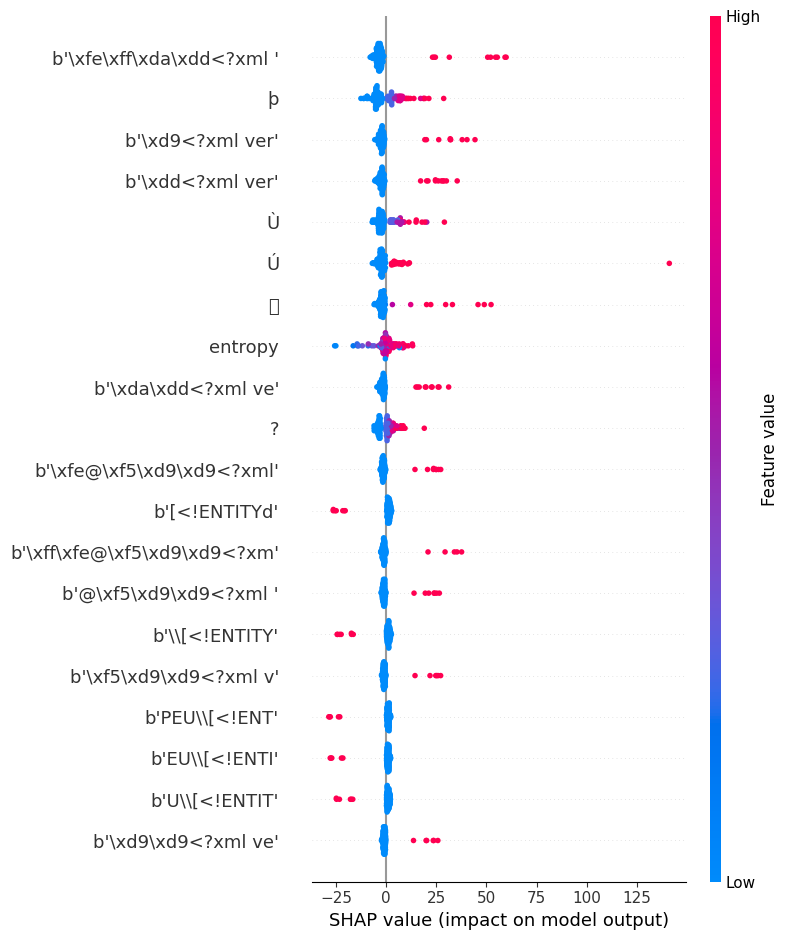

In [11]:
data_for_explanation = next(iter(val_dataloader))
features, _ = data_for_explanation

explainer = shap.GradientExplainer(model, features)
shap_values = explainer.shap_values(features)
shap.summary_plot(shap_values, features, feature_names=list(data.columns))